In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys,os
import numpy as np
import matplotlib.pyplot as plt

##############
#For plotting
import matplotlib.cm as cm

from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True
#rcParams['text.fontsize'] = 18

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

sys.path.append("/Users/bsafdi/Dropbox/galacticB/python/")
sys.path.append("/Users/bsafdi/Dropbox/gmf/")
import galB_models as gB
import gmf 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#gB.B_ASS(-8.5,0,0.01)

In [4]:
# Cas A in Galactic coords
x_sun = -8.5
ell_CA = 0.0#339.54934*np.pi/180.#199.78723027*np.pi/180.#279*np.pi/180. #332.4*np.pi/180. #111.734745*np.pi/180.0 #rads
b_CA = 0.0#-00.40416*np.pi/180.#-08.95860566*np.pi/180.#-31.938*np.pi/180. #-00.37*np.pi/180.#-02.129570*np.pi/180.0 #rads
d_CA = 8.5-30e-3#8.2#3.2 #8.4##1.74#4.22#50.0#3.4 #kpc, to be revised later https://arxiv.org/pdf/astro-ph/0603371.pdf

x_CA = x_sun+d_CA*np.cos(b_CA)*np.cos(ell_CA)
y_CA = d_CA*np.cos(b_CA)*np.sin(ell_CA)
z_CA = d_CA*np.sin(b_CA)
xvec_CA = np.array([x_CA,y_CA,z_CA])
print x_CA,y_CA,z_CA

-0.02999999999999936 0.0 0.0


In [5]:
# Different B-field models
def Bfunct(xv):
    return np.append(gB.B_ASS(xv[0],xv[1],xv[2]),0.0)+gB.Barm(xv[0],xv[1],xv[2])


GMF0=gmf.GMF()
GMFP = gmf.GMF_Pshirkov()
def arctanM(x,y):
    tmp = np.arctan2(x,y)
    if tmp<0:
        res= 2*np.pi+tmp
    else:
        res = tmp
    return res

def B_GMF(x_vec):
    x,y,z = x_vec
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMF0.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMF0.Bhalo(np.array([rho]),np.array([z]))
    Bx,_ = GMF0.BX(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0]+Bx[0])+phi_hat*(disk[1]+halo[1]+Bx[1])+z_hat*(disk[2]+halo[2]+Bx[2])
    return Btot


def B_Psh(x_vec):
    x,y,z = x_vec
    rho = np.sqrt(x**2+y**2)
    phi = arctanM(y,x)
    rho_hat = np.array([x,y,0.0])/rho
    phi_hat = np.array([-y,x,0.0])/rho
    z_hat = np.array([0.0,0.0,1.0])
    
    disk,_ = GMFP.Bdisk(np.array([rho]),np.array([phi]),np.array([z]))
    halo,_ = GMFP.Bhalo(np.array([rho]),np.array([z]))
    
    Btot = rho_hat*(disk[0]+halo[0])+phi_hat*(disk[1]+halo[1])+z_hat*(disk[2]+halo[2])
    return Btot




In [6]:
Bfunct(np.array([-8.5,0,0])), B_GMF(np.array([-8.5,0,0])),B_Psh(np.array([-8.5,0,0]))

(array([ 0.16642205, -0.81799051,  0.        ]),
 array([0.08921106, 0.43848637, 0.24537241]),
 array([0.17431149, 1.9923894 , 0.        ]))

In [7]:
class conversion:
    def __init__(self,xf,Bfunc,xi=np.array([-8.5,0.0,0.00]),ne=3.5e-2,gagg=1e-11,omega=1.0,ma=1e-12):
        #see https://arxiv.org/pdf/1704.05063.pdf for height
        # consider later using Zi = 0.025, for example
        # ne is electrons / cm^3
        # Bfunc shoul be in microGauss
        # gagg in GeV^{-1}
        # ma in eV
        self._xf = xf
        self._xi = xi
        self._compute_geometry()
        self._Bfunc = Bfunc
        self._ne = ne
        self._gagg = gagg
        self._omega = omega
        self._ma = ma
        self._Delta_gammaI = self._Delta_gamma(omega)
        self._Delta_maI = self._Delta_ma(omega)
    
    def _compute_geometry(self):
        rvec = self._xf - self._xi
        self._d = np.linalg.norm(rvec)
        self._rhat = rvec/self._d
        
        if self._rhat[2]>0:
            N = self._rhat
        else:
            N = - self._rhat
        
        r1 = N[0]
        r2 = N[1]
        self._k1 = 1/np.sqrt(1-r2**2)*np.array([-np.sqrt(1-r1**2-r2**2),0,r1])
        self._k2 = np.sqrt(1-r2**2)*np.array([-r1*r2/(1-r2**2),1,-r2*np.sqrt(1-r1**2-r2**2)/(1-r2**2)])

    def _return_Bs(self,r):
        '''
        r in pc and is distance from the Sun
        '''
        rkpc = r*1e-3
        x = self._xi + rkpc*self._rhat
        Bf = self._Bfunc(x)
        return np.dot(Bf,self._k1), np.dot(Bf,self._k2)
        
    def _Delta_gamma(self,omega):
        '''
        omega in keV
        returns in 1/pc
        '''
        return -1.1e-4*(self._ne/1e-3)*(1./omega) #in 1/pc
    
    def _Delta_ma(self,omega):
        '''
        res in pc, omega in keV
        '''
        return -78.0*(self._ma/1e-9)**2*(1./omega)
    
    def _Delta_Bs(self,r):
        '''
        r in pc and is distance from the Sun
        returns in inverse pc
        '''
        B1, B2 = self._return_Bs(r)
        return 1.5e-2*(B1/1.0e3)*(self._gagg/1e-11),1.5e-2*(B2/1.0e3)*(self._gagg/1e-11)
    
    
    def _RHS(self,y,r):
        A1,A2,a = y
        DeltaB1, DeltaB2 = self._Delta_Bs(r)
        Delta_gamma  = self._Delta_gammaI
        Delta_ma = self._Delta_maI
        
        return [-1j*(Delta_gamma*A1+DeltaB1*a),-1j*(Delta_gamma*A2+DeltaB2*a),-1j*(DeltaB1*A1+DeltaB2*A2+Delta_ma*a)]
        
    def _solve_ODE(self,omega=1.0,Nr=10000):
        self._omega = omega
        self._Delta_gammaI = self._Delta_gamma(omega)
        self._Delta_maI = self._Delta_ma(omega)
        dist = self._d*1e3 #in pc
        
        rs = np.linspace(0,dist,Nr)
        
        RHS = lambda r,y: self._RHS(y,r)
        
        sol = solve_ivp(RHS,[0.0,dist] ,[0.0+0*1j,0.0+0*1j,1.0+0*1j],t_eval=rs)
        self.sol = sol
        self.rs = rs
        prob = np.zeros(Nr)
        for i in range(Nr):
            prob[i] = (np.conj(sol.y[0][i])*sol.y[0][i]+np.conj(sol.y[1][i])*sol.y[1][i])
        self.prob = prob
        return prob[-1]#sol
        
        
        
        
    
                 
                 

In [214]:
xvec_CA

array([-0.03,  0.  ,  0.  ])

In [215]:
cI0 = conversion(xvec_CA,Bfunct,ma=1e-15,gagg=1e-12) #B_GMF
cI1 = conversion(xvec_CA,B_GMF,ma=1e-15,gagg=1e-12) #,gagg=1e-11) #B_GMF
cI2 = conversion(xvec_CA,B_Psh,ma=2e-11,gagg=1e-12) #B_GMF

In [216]:
cI1._k1,cI1._k2

(array([-0.,  0., -1.]), array([-0.,  1.,  0.]))

In [217]:
print cI0._return_Bs(100.)
print cI1._return_Bs(100.0)
print cI2._return_Bs(100.0)

(0.0, -0.8214538323532871)
(-0.2539811008985999, 0.4437064487723086)
(0.0, 1.7523730245998392)


In [218]:
tbi_1 = lambda r: cI1._return_Bs(r)[0]
tbi_2 = lambda r: cI1._return_Bs(r)[1]

In [219]:
tbi_1(8400.0)

0.0

In [220]:
from scipy.integrate import cumtrapz

In [221]:
A = np.array([1,20,30,40,50])
x = np.array([1,2,3,4,5])
print cumtrapz(A,x)
#print np.trapz(A[:-1],x[:-1])

[ 10.5  35.5  70.5 115.5]


In [222]:
20/2., 30-20

(10.0, 10)

In [223]:
import numpy as np
from scipy.integrate import cumtrapz

def return_prob(z_array,B_x,B_y,m_a=1e-15,E=10.0,g_agg = 1e-12,**kwargs):
    '''
    return_prob: Axion-photon conversion probability calculation as given in https://arxiv.org/pdf/1903.05088.pdf Eq. (5).
    
    Input:
    ----
    z_array: units [pc].  array of z-values going from the source to the Earth.
    B_x, B_y: units [\mu G]. arrays of the othogonal components of the magnetic field at the z values corresponding to z_array
    m_a: units [eV]. mass of the axion.
    g_agg: units [GeV^{-1}]. axion-photon coupling constant
    E: energy of axion in keV
    n_e: units [cm^{-3}]. free electron density at z values in z_array.  if empty then set to zero
    
    Returns
    ----
    prob: unitless, axion-photon conversion probability 
    '''
    
    ## First we check to see if an array of `n_e` values was given
    if 'n_e' in kwargs.keys():
        n_e = kwargs['n_e']
    else:
        n_e = np.zeros(len(z_array)) #else set to zeros
        
    ## Here we precompute some useful things
    omega_pl = 1.19e-12*np.sqrt((n_e/1e-3)) #$\omega_{pl}$ [units of eV]
    Delta_parr = -0.0781*(omega_pl/1e-10)**2/(E/10.0) # $\Delta_{||}$ [units of pc^{-1}]
    axion_mass_factor = -0.0781*(m_a/1e-10)**2 /(E/10.0) #$\Delta_a$ [units pc^{-1}]
    norm_factor =(g_agg/1e-12)**2*8.8e12*(1e-12)**2/4. #units conversion factor that accounts for g_agg [dimensionless]
    Delta_parr_int = cumtrapz(Delta_parr,z_array) #The integral of $\Delta_{||}$ appearing in exponential of Eq. 5 [dimensionless]
    z_centers = (z_array[1:]+z_array[:-1])/2. #We have to integrate twice, so going to downbin the z_array once
    B_x_centers = (B_x[1:]+B_x[:-1])/2. #down-binned B_x's
    B_y_centers = (B_y[1:]+B_y[:-1])/2. #down-binned B_y's
    
    prob_x_integrand = B_x_centers*np.exp(1j*axion_mass_factor*z_centers -1j*Delta_parr_int ) #The B_x part of the integral
    prob_y_integrand = B_y_centers*np.exp(1j*axion_mass_factor*z_centers -1j*Delta_parr_int ) #The B_y part of integral
    prob_x_complex = np.trapz(prob_x_integrand,z_centers) #Do the integral
    prob_y_complex = np.trapz(prob_y_integrand,z_centers) #Do the integral
    
    # Below, we apply the normalization and compute the conversion probability.  The np.real is just there to convert back to real number type
    prob =  np.real(norm_factor*(prob_x_complex*np.conj(prob_x_complex)+prob_y_complex*np.conj(prob_y_complex)))
    return prob

In [224]:
print 171/145.
from scipy.stats import chi2
print np.array(chi2.interval(0.95,145))/145.

1.17931034483
[0.78314285 1.24295946]


In [225]:
z_arr = np.linspace(0,cI1._d*1e3,int(4e4))
B_arr_x = np.zeros(len(z_arr))
B_arr_y = np.zeros(len(z_arr))
for i in range(len(B_arr_x)):
    Bx,By = cI1._return_Bs(z_arr[i])
    B_arr_x[i] = Bx
    B_arr_y[i] = By

In [226]:
import copy
B_arr_x_2 = copy.deepcopy(B_arr_x)
whs = np.where(B_arr_x==0.0)[0]
B_arr_x_2[whs] = np.min(B_arr_x)

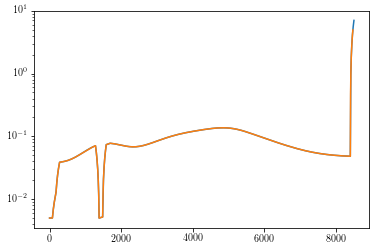

In [242]:

zs,nes = np.load("Quintuplet_NE.npy")#np.load("Wd1_NE.npy")#np.load("Quintuplet_NE.npy")
plt.plot(zs,nes)
plt.yscale('log')

ne_int = np.interp(z_arr,zs,nes)
plt.plot(z_arr,ne_int)

In [243]:
prob_masses = np.geomspace(1e-13, 1e-9, 19)
prob_energies = np.linspace(7.7, 77.7, 176)
conv_probs = np.zeros((len(prob_masses),len(prob_energies)))
for i in range(len(prob_masses)):
    for j in range(len(prob_energies)):
        conv_probs[i,j] = return_prob(z_arr,B_arr_x_2,B_arr_y,E=prob_energies[j],m_a=prob_masses[i],n_e=ne_int)
        
        

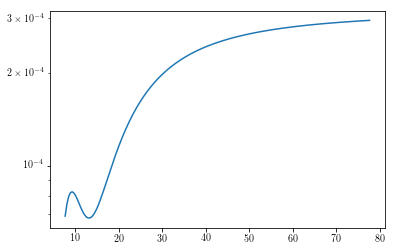

In [244]:
plt.plot(prob_energies,conv_probs[1])
#plt.plot(prob_energies,conv_probs[13])
plt.yscale('log')

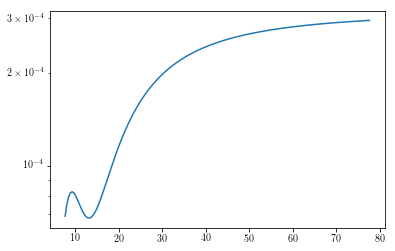

In [245]:
plt.plot(prob_energies,conv_probs[0])
#plt.plot(prob_energies,conv_probs[13])
plt.yscale('log')

In [231]:
os.getcwd()

'/Users/bsafdi/Dropbox (Personal)/galacticB/ipython'

In [232]:
# np.save("conversion_prob_example_Wd1.npy",conv_probs)
np.save("conversion_prob_example_quint.npy",conv_probs)

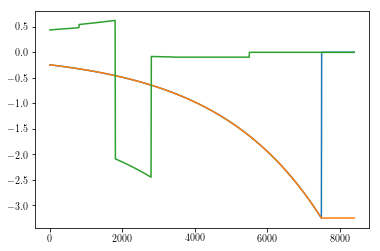

In [118]:
plt.plot(z_arr,B_arr_x)
plt.plot(z_arr,B_arr_x_2)
plt.plot(z_arr,B_arr_y)

In [68]:
5e-7/(0.25)**2, 3e-7/1.2**2

(8e-06, 2.0833333333333333e-07)

In [69]:
0.5e-4*(1/0.00405)**2*(1e11/1e12)**2*(1e-3)**2

3.048315805517453e-08

In [84]:
print cI0._solve_ODE(omega=50.0) #1.9e-4, without is 1.905e-4
print cI1._solve_ODE(omega=100.0)
print cI2._solve_ODE(omega=50.0)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: ComplexWarning: Casting complex values to real discards the imaginary part


0.00010354195669503612
0.00018766931327514295
0.0001854908278744543


In [14]:
5e-7*(0.220/3.4)**-2

0.00011942148760330576

In [15]:
10*(3./50.)**2

0.036

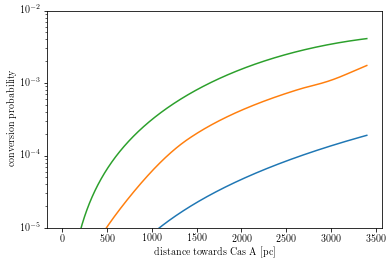

In [141]:
plt.plot(cI0.rs,cI0.prob)
plt.plot(cI1.rs,cI1.prob)
plt.plot(cI2.rs,cI2.prob)
plt.yscale('log')
plt.ylim(1e-5,1e-2)
plt.xlabel("distance towards Cas A [pc]")
plt.ylabel("conversion probability")